In [1]:
%load_ext autoreload
%autoreload 2
from EventDriven.backtest import OptionSignalBacktest
from EventDriven.riskmanager.sizer import DefaultSizer
import pandas as pd
import numpy as np
from IPython.display import clear_output
from dbase.DataAPI.ThetaData import refresh_proxy_url
from copy import deepcopy
from helper import create_backtest_object


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-06-27 15:04:11 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://34.235.162.150:5500/thetadata


Scheduled Data Requests will be saved to: /Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/scheduler/requests.jsonl


In [2]:
create_backtest_object

<function helper.create_backtest_object(cash, weights, trades_, max_cash)>

In [3]:
import os
os.environ['PROXY_URL'] = ''

In [4]:
from EventDriven.riskmanager.sizer import ZscoreRVolSizer
# ZscoreRVolSizer?


In [5]:
import json
keys = [4, 5, 6, 7, 8, 9, 10, 11, 12 ]
imports_trades = {key: {'trades': pd.read_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_trades_{key}.csv').iloc[:, 1:]} for key in keys}

for key in keys:
    with open(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_weights_{key}.json', 'r') as f:
        weights = json.load(f)
        symbol_list = imports_trades[key]['trades'].Ticker.unique()
        untraded_symbols = [s for s in weights.keys() if s not in imports_trades[key]['trades'].Ticker.unique()]
        imports_trades[key]['weights'] = weights

In [6]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo
filename = 'dte_270_roll_120'
ending_capital = 20_000
initial_capital = ending_capital
capital_tracking = {}
objects = {}
for key in keys:
    print(f"Starting backtest for key: {key}, with initial capital: {ending_capital}")
    print(f"Previous Backtest Starting Capital: {initial_capital}, Ending capital from Previous Backtest: {ending_capital}, Return: {((ending_capital - initial_capital) / initial_capital) * 100}% \n")
    initial_capital = ending_capital
    print(f"Current Capital Tracking: {capital_tracking}")

    ## Set the trades and weights
    trades_ = imports_trades[key]['trades']
    weights = imports_trades[key]['weights']
    objects[key] = {}
    print(weights)

    ## Produce max cash map
    max_cash = {}
    cash = initial_capital
    for s, w in weights.items():
        print(f'{s} {w} {w * cash}')
        if w * cash > 500:
            max_cash[s] = 4
        elif w * cash > 300:
            max_cash[s] = 3
        elif w * cash > 200:
            max_cash[s] = 2
        elif w * cash > 100:
            max_cash[s] = 1
        else:
            max_cash[s] = 0.5
    print(max_cash)

    ## Create the backtest object
    evb_backtest = create_backtest_object(cash, weights, trades_, max_cash)
    evb_backtest.portfolio.roll_map = 120
    evb_backtest.portfolio.order_settings['target_dte'] = 270
    # sizer = ZscoreRVolSizer(evb_backtest.portfolio, 
    #                         evb_backtest.risk_manager, 
    #                         evb_backtest.risk_manager.sizing_lev,
    #                         vol_type = 'weighted_mean')
    # sizer.norm_constant = 2
    # evb_backtest.portfolio.risk_manager.sizer = sizer

    evb_backtest.portfolio.risk_manager.print_settings()

    custom_attr = {
    'max_cash': max_cash,
    'w_map': evb_backtest.portfolio.weight_map,
    'initial_capital': initial_capital,
    'commission_rate': evb_backtest.executor.max_slippage_pct,
    'max_slippage_pct':evb_backtest.executor.commission_rate,
    'roll_map': evb_backtest.portfolio.roll_map,
    'order_settings': evb_backtest.portfolio.order_settings,
    'sizing_lev': evb_backtest.portfolio.risk_manager.sizing_lev,
    'limits': evb_backtest.portfolio.risk_manager.limits,
    't_plus_n': evb_backtest.portfolio.risk_manager.t_plus_n,
    'otm_moneyness_width': evb_backtest.portfolio.risk_manager.otm_moneyness_width,
    'itm_moneyness_width': evb_backtest.portfolio.risk_manager.itm_moneyness_width,
    }
    ## Run the backtest
    evb_backtest.run()

    ## Get the ending capital
    ending_capital = evb_backtest.portfolio._equity['Total'][-1]
    # initial_capital = ending_capital
    capital_tracking[key] = ending_capital
    objects[key]['WEIGHTS'] = evb_backtest.portfolio.weight_map
    objects[key]['END_CASH'] = ending_capital
    objects[key]['TEST_RESULT'] = {}
    objects[key]['TEST_RESULT']['BACKTESTER'] = evb_backtest
    objects[key]['TEST_RESULT']['AGG'] = evb_backtest.portfolio.aggregate()
    objects[key]['CUSTOM_ATTR'] = custom_attr
    clear_output(wait=True)

Starting backtest for key: 12, with initial capital: 371953.15314561746
Previous Backtest Starting Capital: 358010.1295060723, Ending capital from Previous Backtest: 371953.15314561746, Return: 3.894589144385828% 

Current Capital Tracking: {4: 52782.92737033928, 5: 62450.57040102243, 6: 79499.42160518514, 7: 345856.54925719654, 8: 365292.2718540005, 9: 349374.5492211222, 10: 358010.1295060723, 11: 371953.15314561746}
{'NVDA': 0.3717903440438027, 'TSLA': 0.13285856444949615, 'META': 0.11763798538677593, 'NFLX': 0.08637009747959587, 'AMD': 0.0472536240089943, 'AAPL': 0.0676151517402857, 'COST': 0.0720078264760282, 'AMZN': 0.04879875274933317, 'BA': 0.02991981454758278, 'SBUX': 0.025747839118105225}
NVDA 0.3717903440438027 138288.59077618635
TSLA 0.13285856444949615 49417.16196939033
META 0.11763798538677593 43755.819594309374
NFLX 0.08637009747959587 32125.630095030032
AMD 0.0472536240089943 17576.134447702883
AAPL 0.0676151517402857 25149.66889021865
COST 0.0720078264760282 26783.53810

AttributeError: 'DataFrame' object has no attribute 'ReturnPct'

In [1]:
from module_test.raw_code.DataManagers import OptionDataManager
dm = OptionDataManager(opttick = 'AMZN20190621C2185')
req = dm.get_timeseries(start = '2017-01-01', end = '2025-06-01')
req


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-06-27 14:46:28 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://34.235.162.150:5500/thetadata


Scheduled Data Requests will be saved to: /Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/scheduler/requests.jsonl
[get_engine] Creating engine for DB: securities_master, PID: 43043
2025-06-27 14:46:56 trade.asset.Stock ERROR: Error getting dividends history for AMZN from yfinance
2025-06-27 14:46:56 trade.asset.Stock ERROR: Probably due to no dividends history


DatabaseError: (mysql.connector.errors.DatabaseError) 2003 (HY000): Can't connect to MySQL server on '47.24.142.115:3306' (60)
(Background on this error at: https://sqlalche.me/e/20/4xp6)

In [12]:
evb_backtest.risk_manager.skip_adj_count

0

In [13]:
import dill

with open(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/{filename}.pkl', 'wb') as f:
    dill.dump(objects, f)

In [32]:
objects[8]['TEST_RESULT']['BACKTESTER'].risk_manager.special_dividends.dir

PosixPath('/Users/chiemelienwanisobi/cloned_repos/QuantTools/.cache/special_dividend')

In [16]:
capital_tracking

{4: 53187.22786574059,
 5: 83788.35453298305,
 6: 110166.44707065693,
 7: 159402.17313519586,
 8: 168437.96848628556,
 9: 161685.8364773095,
 10: 165856.48626821616,
 11: 172313.34733296486,
 12: 160286.98250989043}

In [16]:
capital_tracking[12]

6350777.853081709

In [6]:
# objects[11]['TEST_RESULT']['BACKTESTER'].plot_portfolio()
key = 12
eq = objects[key]['TEST_RESULT']['BACKTESTER']._equity
trades = objects[key]['TEST_RESULT']['BACKTESTER'].trades
transactions = objects[key]['TEST_RESULT']['BACKTESTER'].transactions
ob = objects[key]['TEST_RESULT']['BACKTESTER']
ob.plot_portfolio()

2025-06-23 15:26:01 trade.asset.Stock ERROR: Error getting previous close for SPY from yfinance: 'prev_close'


In [8]:

trades[trades.Ticker == 'AAPL'][['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'Duration']]

,SignalID,Ticker,ReturnPct,Positions,EntryTime,ExitTime,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,Duration
1,AAPL20240103LONG,AAPL,-0.301643,&L:AAPL20250117C220&S:AAPL20241220C225,2024-01-03,2024-02-16,210.628784,147.094075,1255.972703,890.364450,44
10,AAPL20240513LONG,AAPL,0.775969,&L:AAPL20250620C205&S:AAPL20250620C210,2024-05-13,2024-12-31,205.726732,365.364251,1022.133658,1833.321256,232


<Axes: xlabel='Datetime'>

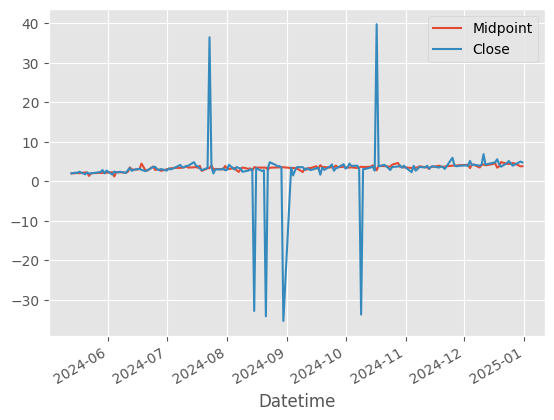

In [9]:
opt_data = objects[11]['TEST_RESULT']['BACKTESTER'].options_data['AAPL20250620C205'] - objects[11]['TEST_RESULT']['BACKTESTER'].options_data['AAPL20250620C210']
opt_data[(opt_data.index >= '2024-05-13') & (opt_data.index <= '2024-12-31')].plot(y = ['Midpoint', 'Close'])

In [10]:
from dbase.DataAPI.ThetaData import retrieve_eod_ohlc,retrieve_quote
retrieve_quote('NVDA', 
                  '2024-12-20',
                  '2025-01-17',
                  'C',
                  '2024-01-12',
                  595.0,
                  print_url=True)

http://127.0.0.1:25510/v2/hist/option/quote?end_date=20241220&root=NVDA&use_csv=true&exp=20250117&ivl=1800000&right=C&start_date=20240112&strike=595000&start_time=34200000&rth=False&end_time=57600000


,Bid_size,Bid_exchange,Bid,Bid_condition,Ask_size,Ask_exchange,Ask,Ask_condition,Date,Midpoint,Weighted_midpoint,time
datetime,,,,,,,,,,,,
2024-01-12 09:30:00,0,1,0.00,50,0,1,0.00,50,20240112,0.000,NaN,09:30:00
2024-01-12 10:00:00,18,73,81.90,50,37,5,82.35,50,20240112,82.125,82.202727,10:00:00
2024-01-12 10:30:00,15,69,81.95,50,28,69,82.40,50,20240112,82.175,82.243023,10:30:00
2024-01-12 11:00:00,19,69,80.70,50,53,5,81.05,50,20240112,80.875,80.957639,11:00:00
2024-01-12 11:30:00,23,69,81.85,50,25,46,82.15,50,20240112,82.000,82.006250,11:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10 14:00:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,14:00:00
2024-06-10 14:30:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,14:30:00
2024-06-10 15:00:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,15:00:00


In [11]:
retrieve_eod_ohlc?

Signature:
retrieve_eod_ohlc(
    symbol,
    end_date: str,
    exp: str,
    right: str,
    start_date: str,
    strike: float,
    print_url=False,
    rt=True,
    proxy='http://18.232.166.224:5500/thetadata',
    **kwargs,
)
Docstring: Interval size in miliseconds. 1 minute is 6000
File:      ~/cloned_repos/FinanceDatabase/dbase/DataAPI/ThetaData.py
Type:      function

In [12]:
objects[11]['TEST_RESULT']['AGG']

Start                                                    2024-01-03 00:00:00
End                                                      2024-12-31 00:00:00
Duration                                                   363 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    55008.92
Equity Peak [$]                                                 92562.581779
Return [%]                                                        160.789903
Buy & Hold Return [%]                                               54.89812
CAGR [%]                                                           162.17084
Volatility Ann. [%]                                               169.099939
Sharpe Ratio                                                        1.381638
Sortino Ratio                                                       2.085216
Skew                                                                1.047743

In [13]:
    # ## Initialize the backtest class
    # evb_backtest = OptionSignalBacktest(trades_, initial_capital=cash, t_plus_n=1)
    # evb_backtest.portfolio.initial_capital
    # w_map = {x: w  * 0.95 for x, w in weights.items()} ## 75% of the weights for each stock
    # evb_backtest.portfolio.weight_map = w_map
    # # evb_backtest.portfolio.weight_map
    # # evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
    # # evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
    # evb_backtest.portfolio.risk_manager.sizing_lev = 4.5
    # # evb_backtest.portfolio.max_contract_price_factor = 2
    # # evb_backtest.portfolio.min_moneyness_threshold = 3
    # # evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
    # order_settings =  {
    #             'type': 'spread',
    #             'specifics': [
    #                 {'direction': 'long', 'rel_strike': 1.0, 'dte': 365, 'moneyness_width': 0.1},
    #                 {'direction': 'short', 'rel_strike': 0.85, 'dte': 365, 'moneyness_width': 0.1} 
    #             ],
    #             'name': 'vertical_spread',
    #             'strategy': 'vertical',
    #             'target_dte': 360, #270
    #             'structure_direction': 'long',
    #             'spread_ticks': 1,
    #             'dte_tolerance': 60,
    #             'min_moneyness': 0.65, #0.75
    #             'max_moneyness': 1., #1.25
    #             'min_total_price': 0.95 #0.5
    #         }
    # evb_backtest.portfolio.order_settings = order_settings
    # evb_backtest.portfolio.risk_manager.max_dte_tolerance = order_settings['target_dte'] - 240
    # evb_backtest.portfolio.risk_manager.max_tries = 15
    # evb_backtest.portfolio.max_contract_price = max_cash
    # evb_backtest.executor.commission_rate = 0.65/100
    # # evb_backtest.portfolio.min_moneyness_threshold = 5
    # evb_backtest.executor.max_slippage_pct = 0.075
    # evb_backtest.portfolio.roll_map = 180
    # # evb_backtest.portfolio.moneyness_width_factor = .025
    # # evb_backtest.portfolio.dte_reduction_factor = 30
    # # evb_backtest.portfolio.min_acceptable_dte_threshold = 95
    # evb_backtest.portfolio.risk_manager.limits['dte'] = True
    # evb_backtest.portfolio.risk_manager.limits['delta'] = True
    # evb_backtest.portfolio.risk_manager.limits['moneyness'] = True
    # evb_backtest.portfolio.risk_manager.max_moneyness = 1.15 #1.05
    # evb_backtest.portfolio.risk_manager.max_slippage = 0.075
    # evb_backtest.portfolio.risk_manager.otm_moneyness_width = 0.45
    # evb_backtest.portfolio.risk_manager.itm_moneyness_width = 0.10
    # evb_backtest.portfolio.risk_manager.re_update_on_roll = False
    # evb_backtest.portfolio.risk_manager.t_plus_n = 1
    # pm, rm = evb_backtest.portfolio, evb_backtest.portfolio.risk_manager
    # evb_backtest.risk_manager.sizer = DefaultSizer(pm, rm, rm.sizing_lev)
    # for k  in max_cash:
    #     if max_cash[k]*100 > evb_backtest.portfolio.allocated_cash_map[k]:
    #         print(k, max_cash[k]*100, evb_backtest.portfolio.allocated_cash_map[k])

{'WEIGHTS': {'NVDA': 0.193113327353184,
  'TSLA': 0.10597235406416428,
  'AMD': 0.06088781342963995,
  'AAPL': 0.09449359902353249,
  'NFLX': 0.05972035693343455,
  'COST': 0.06444958682546627,
  'AMZN': 0.043240968324206666,
  'BA': 0.0467708109001976,
  'SBUX': 0.04668659972930734},
 'END_CASH': 15014.71964973706,
 'TEST_RESULT': {'BACKTESTER': <EventDriven.portfolio.OptionSignalPortfolio at 0x143267f50>,
  'AGG': Start                                                    2022-01-04 00:00:00
  End                                                      2022-12-30 00:00:00
  Duration                                                   360 days 00:00:00
  Exposure Time [%]                                                      77.61
  Equity Final [$]                                                    15014.72
  Equity Peak [$]                                                 23475.760782
  Return [%]                                                        -34.198667
  Buy & Hold Return [%]      

In [14]:
imports_trades[9]['trades'].PnL.sum(),imports_trades[9]['trades'].PnL.shape

(-12953.237079659477, (21,))

In [15]:

imports_trades[9]['weights']['NVDA'] * 20000

5149.688729418241